In [ ]:
import pandas as pd
import cv2
import numpy as np
import os
import seaborn as sns
from glob import glob
from google.colab import drive
from matplotlib.image import imread
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import (accuracy_score, classification_report,
                             roc_curve, auc, roc_auc_score)
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.model_selection import RandomizedSearchCV
from sklearn.decomposition import PCA

drive.mount('/content/drive/')
fire_path = '/content/drive/MyDrive/CSS581-Project/forest_fire'

# Currently using data from: https://www.kaggle.com/datasets/brsdincer/wildfire-detection-image-data/data
# # images are all 250 * 250 pixels

# Define training paths and combine training files
fire_train_path = "/content/drive/MyDrive/CSS581-Project/forest_fire/Training and Validation/fire"
no_fire_train_path = "/content/drive/MyDrive/CSS581-Project/forest_fire/Training and Validation/nofire"
fire_train_images = glob(os.path.join(fire_train_path, "*"))
no_fire_train_images = glob(os.path.join(no_fire_train_path, "*"))
train_files = glob(os.path.join(fire_train_path, "*")) + glob(os.path.join(no_fire_train_path, "*"))
print(len(train_files))

# Define testing paths and combine training files
fire_test_path = "/content/drive/MyDrive/CSS581-Project/forest_fire/Testing/fire"
no_fire_test_path = "/content/drive/MyDrive/CSS581-Project/forest_fire/Testing/nofire"
fire_test_images = glob(os.path.join(fire_test_path, "*"))
no_fire_test_images = glob(os.path.join(no_fire_test_path, "*"))
test_files = glob(os.path.join(fire_test_path, "*")) + glob(os.path.join(no_fire_test_path, "*"))
print(len(test_files))

print("Fire Training Images:", len(os.listdir(fire_train_path)))
print("No Fire Training Images:", len(os.listdir(no_fire_train_path)))
print("Fire Testing Images:", len(os.listdir(fire_test_path)))
print("No Fire Testing Images:", len(os.listdir(no_fire_test_path)))

# ---- Functions ----
def plot_pca(train_data):
  pca = PCA(n_components=2)
  X_train_pca = pca.fit_transform(train_data)

  plt.figure(figsize=(8, 6))
  scatter = plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap='viridis', alpha=0.7)
  plt.xlabel("PC1")
  plt.ylabel("PC2")
  plt.title(f"PCA of Cluster Distances ({k} Clusters)")
  plt.colorbar(scatter, label="True Label")
  plt.show()
  print()

def display_misclassified_images(image_paths, y_true, y_pred, num_images=10):
  """
  Displays misclassified images with their true and predicted labels.

  Args:
      image_paths (list): List of file paths for the test images.
      y_true (array): True labels for the images.
      y_pred (array): Predicted labels from the model.
      num_images (int): Number of misclassified images to display.
  """
  # Find indices of misclassified images
  misclassified_indices = [i for i, (true, pred) in enumerate(zip(y_true, y_pred)) if true != pred]

  # Handle case when there are fewer misclassifications than requested
  num_images = min(num_images, len(misclassified_indices))
  if num_images == 0:
      print("No misclassified images found!")
      return

  # Set up the plot
  fig, axes = plt.subplots(1, num_images, figsize=(10, 5))
  if num_images == 1:
      axes = [axes]  # Ensure axes is iterable even for a single image

  displayed = 0  # Counter for displayed images
  for idx in misclassified_indices[:num_images]:
      img_path = image_paths[idx]
      img = cv2.imread(img_path)

      # Skip missing or unreadable images
      if img is None:
          print(f"Skipping missing image: {img_path}")
          continue

      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
      # img = cv2.resize(img, (128, 128))  # Resize for consistency

      # Plot the misclassified image
      ax = axes[displayed]
      ax.imshow(img)
      true_label = "Fire" if y_true[idx] == 1 else "No Fire"
      pred_label = "Fire" if y_pred[idx] == 1 else "No Fire"
      ax.set_title(f"True: {true_label}\nPred: {pred_label}", fontsize=10)
      ax.axis("off")
      displayed += 1

  plt.tight_layout()
  plt.show()

def train_models(X_train, y_train, X_test, y_test):
  # --- Define Classifiers ---
  rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
  log_reg = LogisticRegression(max_iter=1000)

  models = {
      "RandomForest": rf_clf,
      "LogisticRegression": log_reg
  }

  # Dictionary to store ROC data for each model
  roc_data = {}

  # --- Train, Evaluate, and Display Misclassified Images for Each Model ---
  for model_name, clf in models.items():
      # Train the classifier
      clf.fit(X_train, y_train)
      y_pred = clf.predict(X_test)

      # Get probability estimates for the positive class (needed for ROC)
      y_prob = clf.predict_proba(X_test)[:, 1]

      # Print performance metrics
      acc = accuracy_score(y_test, y_pred)
      print(f"--- {model_name} ---")
      print(f"Accuracy: {acc:.4f}")
      print("Classification Report:")
      print(classification_report(y_test, y_pred))

      # Compute ROC curve and ROC AUC
      fpr, tpr, thresholds = roc_curve(y_test, y_prob)
      roc_auc = auc(fpr, tpr)
      roc_data[model_name] = (fpr, tpr, roc_auc)
      print(f"ROC AUC: {roc_auc:.4f}")

      # Display misclassified images for this model
      display_misclassified_images(test_files, y_test, y_pred, num_images=10)


  # --- Plot All ROC Curves on One Graph ---
  plt.figure(figsize=(8, 6))
  for model_name, (fpr, tpr, roc_auc) in roc_data.items():
      plt.plot(fpr, tpr, lw=2, label=f"{model_name} (AUC = {roc_auc:.4f})")
  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  plt.title("ROC Curves for All Models")
  plt.legend(loc="lower right")
  plt.show()

Mounted at /content/drive/
1832
68
Fire Training Images: 928
No Fire Training Images: 904
Fire Testing Images: 22
No Fire Testing Images: 46


In [ ]:
# # RUN

# # VGG Processessing
# # This will load a model that is already trained to extract features from images

from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import numpy as np
import os
from glob import glob

# Load VGG16 without the classification head
# # VGG Takes the images as 224 x 224
vgg_model = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
vgg_model_gray = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3)) # The grey channels are replecated across the three channels (which VGG needs)

# Load images and extract features using VGG
def load_images_vgg(folder_path, label):
    images = []
    labels = []

    for img_path in glob(os.path.join(folder_path, "*")):
        img = load_img(img_path, target_size=(224, 224))  # Resize
        img = img_to_array(img)  # Convert to array
        img = preprocess_input(img)  # Preprocess according to VGG16
        features = vgg_model.predict(np.expand_dims(img, axis=0))  # Extract features
        features = features.flatten()  # Flatten the feature map

        images.append(features)
        labels.append(label)

    return images, labels

# Load images in grayscale and extract features using VGG
def load_images_vgg_gray(folder_path, label):
    images = []
    labels = []

    for img_path in glob(os.path.join(folder_path, "*")):
        # Load the image in grayscale
        img = load_img(img_path, color_mode="grayscale", target_size=(224, 224))

        # Convert to array and replicate across 3 channels
        img = img_to_array(img)  # Shape: (224, 224, 1)
        img = np.repeat(img, 3, axis=-1)  # Convert to 3 channels (224, 224, 3)

        # Preprocess according to VGG16
        img = preprocess_input(img)

        # Extract features
        features = vgg_model_gray.predict(np.expand_dims(img, axis=0))  # Expand for batch
        features = features.flatten()  # Flatten feature map

        images.append(features)
        labels.append(label)

    return images, labels

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
# RUN

# VGG FEATURE EXTRACTION
fire_train_features, fire_train_labels = load_images_vgg(fire_train_path, label=1)
no_fire_train_features, no_fire_train_labels = load_images_vgg(no_fire_train_path, label=0)

fire_test_features, fire_test_labels = load_images_vgg(fire_test_path, label=1)
no_fire_test_features, no_fire_test_labels = load_images_vgg(no_fire_test_path, label=0)

# Combine training data and labels
X_train = np.array(fire_train_features + no_fire_train_features)
y_train = np.array(fire_train_labels + no_fire_train_labels)

# Combine testing data and labels
X_test = np.array(fire_test_features + no_fire_test_features)
y_test = np.array(fire_test_labels + no_fire_test_labels)

print(f"X_train.shape: {X_train.shape}")  # Should be (num_images, 512)
print(f"Number of bins per image: {len(X_train[0])}")  # Should be 512


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 939ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 583ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 607ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 591ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 595ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 995ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 979ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 607ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 581ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 988ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 961ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 937ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 949ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 694ms/step
1/1 ━━━

(1832, 25088)


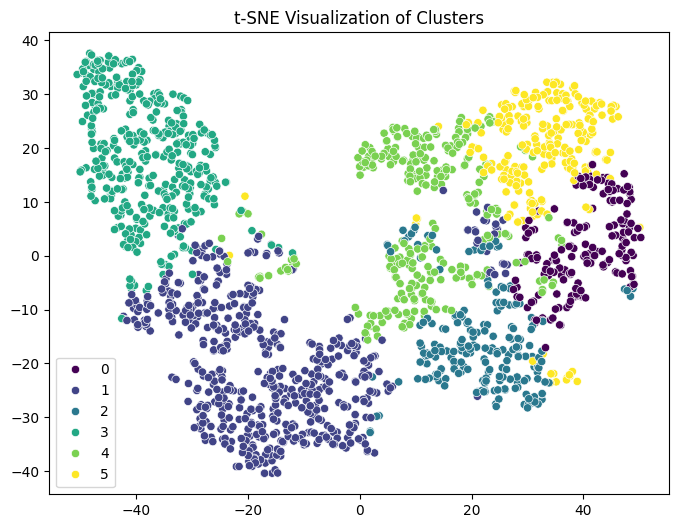

(1832, 5)


In [ ]:
# Apply PCA and display TSNE clusters

from sklearn.decomposition import PCA

# Shapre (num_images, 244 x 244 x 3)
print(X_train.shape)

# Reduce to 100 dimensions (or try smaller values like 50)
pca = PCA(n_components=5, random_state=42)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

from sklearn.manifold import TSNE
import seaborn as sns

# Visualize the clusters
# Shows that the clusters are well defined
tsne = TSNE(n_components=2, random_state=42)
X_train_2d = tsne.fit_transform(X_train_pca)

k = 6
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
kmeans.fit(X_train_pca)
labels = kmeans.labels_

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_train_2d[:, 0], y=X_train_2d[:, 1], hue=labels, palette='viridis')
plt.title("t-SNE Visualization of Clusters")
plt.show()


print(X_train_pca.shape)

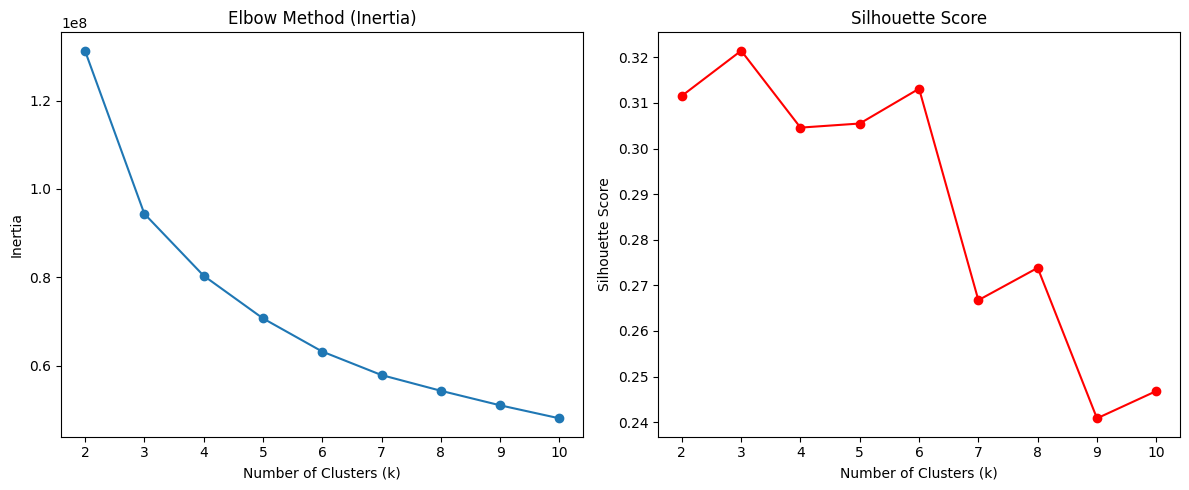

In [ ]:
from sklearn.metrics import silhouette_score

# Guaging which value of K is optimal
# Elbow Plot (Inertia):

# Look for a point where the curve starts to “bend” or flatten out. That might be a good trade-off between cluster count and variance explained.

# Silhouette Score Plot:
# Higher silhouette scores (closer to 1) mean better-defined clusters.
# A peak in the silhouette curve can suggest an optimal 𝑘

# Range of k values to try
k_values = range(2, 11)

inertias = []
silhouette_scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    # kmeans.fit(X_train_scaled)
    kmeans.fit(X_train_pca)

    # Inertia: sum of squared distances of samples to their closest cluster center
    inertias.append(kmeans.inertia_)

    # Silhouette Score: how similar a sample is to its own cluster vs. other clusters
    labels = kmeans.labels_
    sil_score = silhouette_score(X_train_pca, labels)
    silhouette_scores.append(sil_score)

# Plot Inertia (Elbow Method)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(k_values, inertias, marker='o')
plt.xticks(np.arange(min(k_values), max(k_values) + 1, 1))  # Ensures whole number x-axis
plt.title('Elbow Method (Inertia)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')

# Plot Silhouette Scores
plt.subplot(1, 2, 2)
plt.plot(k_values, silhouette_scores, marker='o', color='red')
plt.xticks(np.arange(min(k_values), max(k_values) + 1, 1))  # Ensures whole number x-axis
plt.title('Silhouette Score')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')

plt.tight_layout()
plt.show()

X_train shape:  (1832, 25088)
--- RandomForest ---
Accuracy: 1.0000
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        46
           1       1.00      1.00      1.00        22

    accuracy                           1.00        68
   macro avg       1.00      1.00      1.00        68
weighted avg       1.00      1.00      1.00        68

ROC AUC: 1.0000
No misclassified images found!
--- LogisticRegression ---
Accuracy: 0.9853
Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        46
           1       1.00      0.95      0.98        22

    accuracy                           0.99        68
   macro avg       0.99      0.98      0.98        68
weighted avg       0.99      0.99      0.99        68

ROC AUC: 1.0000


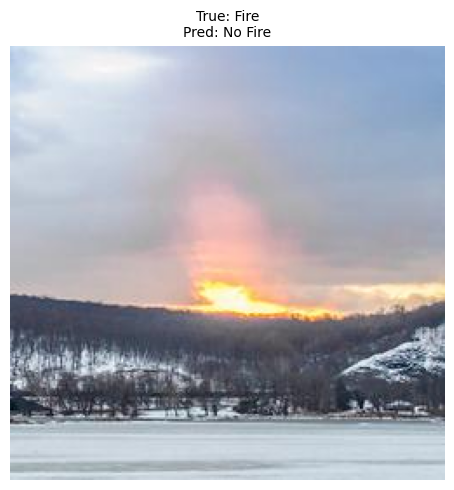

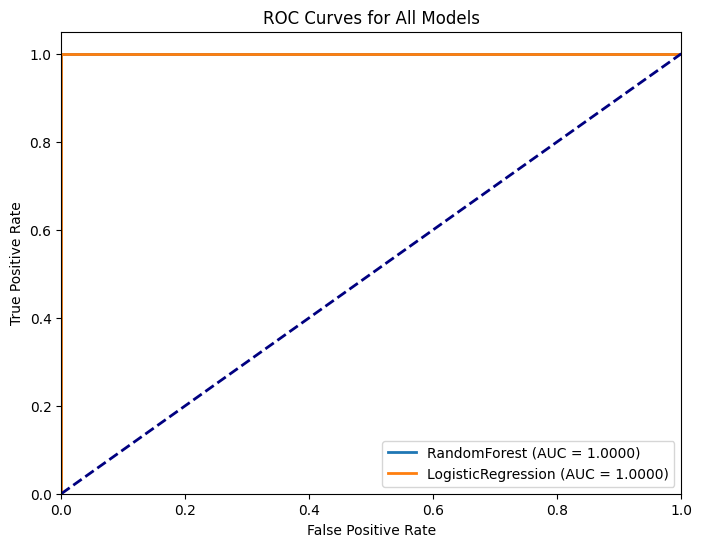

In [ ]:
#@title RGB RAW PIXEL TRAINING

print("X_train shape: ", X_train.shape)
train_models(X_train, y_train, X_test, y_test)

In [ ]:
# RUN

# Apply K-Means Clustering
k = 6
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)

KMeans Label X_Train Shape:  (1832, 1)
--- RandomForest ---
Accuracy: 0.9412
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96        46
           1       0.91      0.91      0.91        22

    accuracy                           0.94        68
   macro avg       0.93      0.93      0.93        68
weighted avg       0.94      0.94      0.94        68

ROC AUC: 0.9585


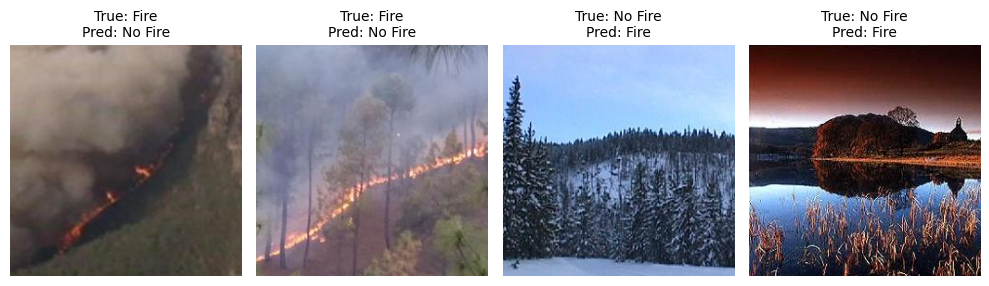

--- LogisticRegression ---
Accuracy: 0.7353
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.74      0.79        46
           1       0.57      0.73      0.64        22

    accuracy                           0.74        68
   macro avg       0.71      0.73      0.72        68
weighted avg       0.76      0.74      0.74        68

ROC AUC: 0.8577


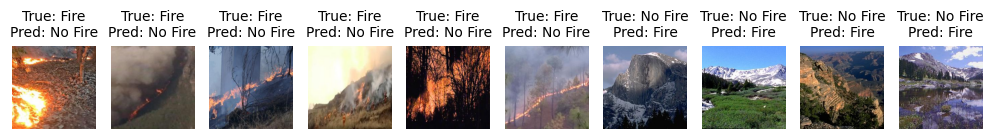

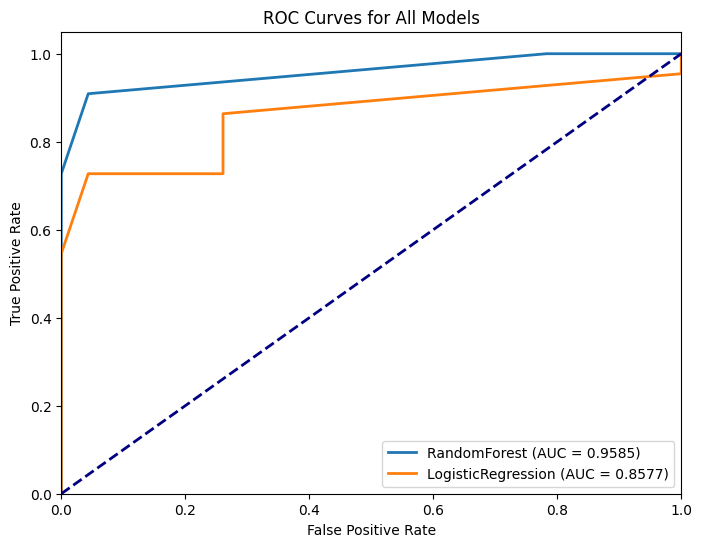

In [ ]:
#@title RGB KMEANS CLUSTER LABELS

X_train_clustered = kmeans.fit_predict(X_train_pca).reshape(-1, 1)
X_test_clustered = kmeans.predict(X_test_pca).reshape(-1, 1)

print("KMeans Label X_Train Shape: ", X_train_clustered.shape)
train_models(X_train_clustered, y_train, X_test_clustered, y_test)

KMeans Distances X_Train Shape:  (1832, 6)
--- RandomForest ---
Accuracy: 0.9706
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98        46
           1       0.95      0.95      0.95        22

    accuracy                           0.97        68
   macro avg       0.97      0.97      0.97        68
weighted avg       0.97      0.97      0.97        68

ROC AUC: 0.9980


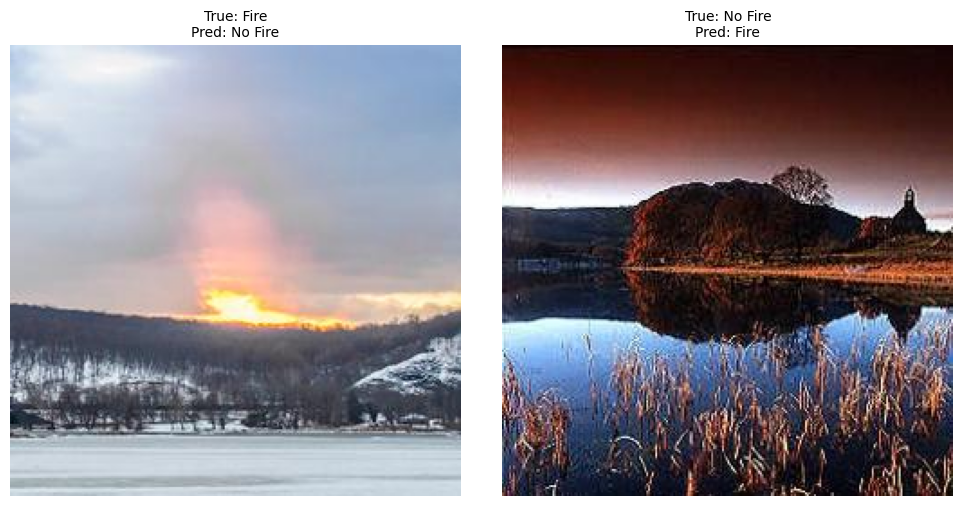

--- LogisticRegression ---
Accuracy: 0.9853
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99        46
           1       0.96      1.00      0.98        22

    accuracy                           0.99        68
   macro avg       0.98      0.99      0.98        68
weighted avg       0.99      0.99      0.99        68

ROC AUC: 1.0000


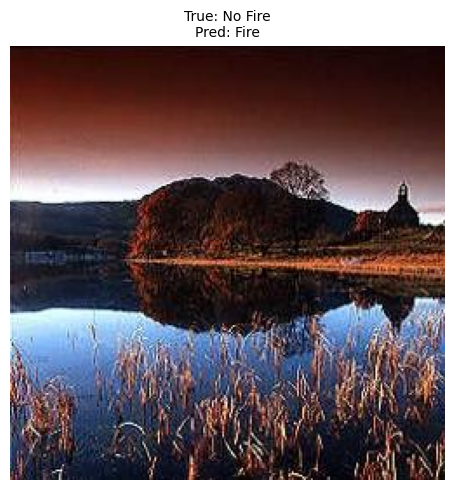

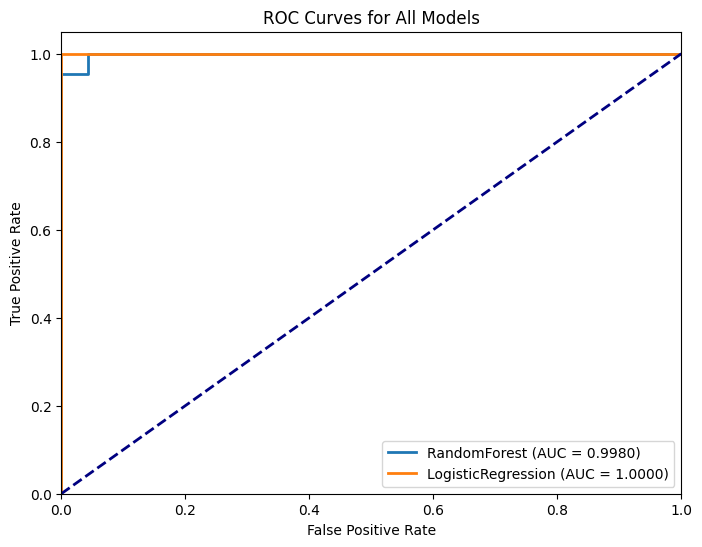

In [ ]:
#@title RGB KMEANS CLUSTER DISTANCES

#   Center is the the mean position of all the points belonging to that cluster in the feature space
#   The center represents the mean value of the cluster
#   The center is continuously calculated until it stabalizes


X_train_dist = kmeans.transform(X_train_pca)
X_test_dist = kmeans.transform(X_test_pca)

print("KMeans Distances X_Train Shape: ", X_train_dist.shape)
# (Num train images, num_clusters)

train_models(X_train_dist, y_train, X_test_dist, y_test)

In [ ]:
#@title --- GREYSCALE ---
# VGG FEATURE EXTRACTION
gray_fire_train_features, gray_fire_train_labels = load_images_vgg_gray(fire_train_path, label=1)
gray_no_fire_train_features, gray_no_fire_train_labels = load_images_vgg_gray(no_fire_train_path, label=0)

gray_fire_test_features, gray_fire_test_labels = load_images_vgg_gray(fire_test_path, label=1)
gray_no_fire_test_features, gray_no_fire_test_labels = load_images_vgg_gray(no_fire_test_path, label=0)

# Combine training data and labels
gray_X_train = np.array(gray_fire_train_features + gray_no_fire_train_features)
gray_y_train = np.array(gray_fire_train_labels + gray_no_fire_train_labels)

# Combine testing data and labels
gray_X_test = np.array(gray_fire_test_features + gray_no_fire_test_features)
gray_y_test = np.array(gray_fire_test_labels + gray_no_fire_test_labels)

# Reduce to 100 dimensions (or try smaller values like 50)
pca = PCA(n_components=5, random_state=42)
gray_X_train_pca = pca.fit_transform(gray_X_train)
gray_X_test_pca = pca.transform(gray_X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 849ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 591ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 584ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 575ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 571ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 599ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 573ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 577ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 584ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 577ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 592ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 695ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 961ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 583ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 588ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 

--- RandomForest ---
Accuracy: 0.9706
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98        46
           1       0.95      0.95      0.95        22

    accuracy                           0.97        68
   macro avg       0.97      0.97      0.97        68
weighted avg       0.97      0.97      0.97        68

ROC AUC: 0.9926


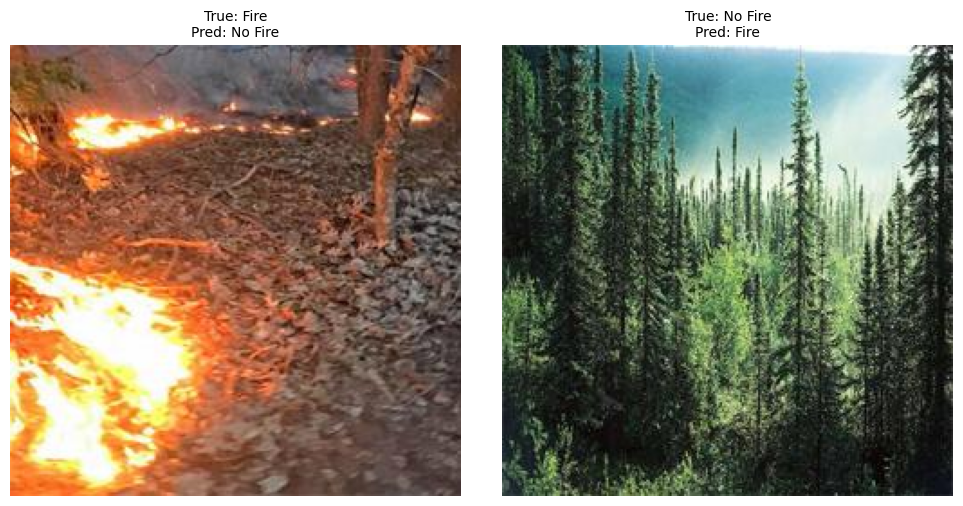

--- LogisticRegression ---
Accuracy: 0.9706
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98        46
           1       0.95      0.95      0.95        22

    accuracy                           0.97        68
   macro avg       0.97      0.97      0.97        68
weighted avg       0.97      0.97      0.97        68

ROC AUC: 0.9970


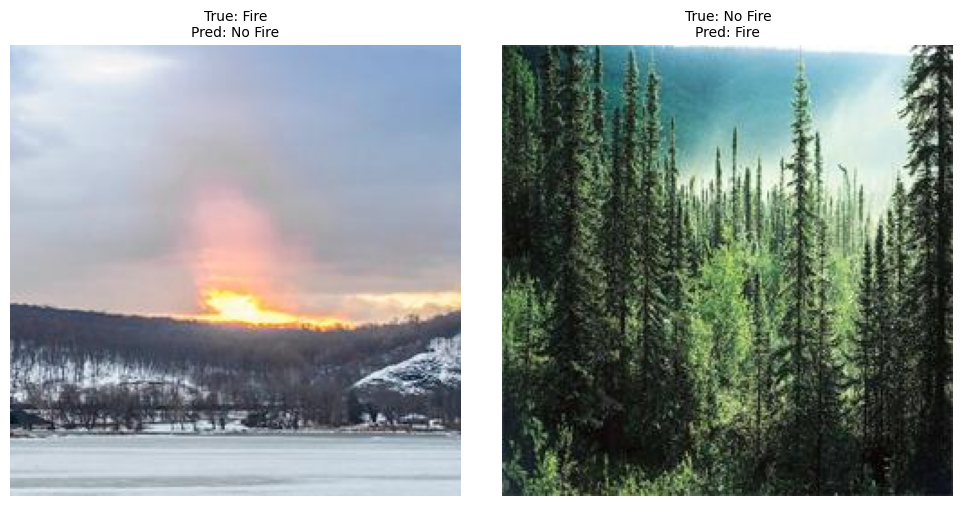

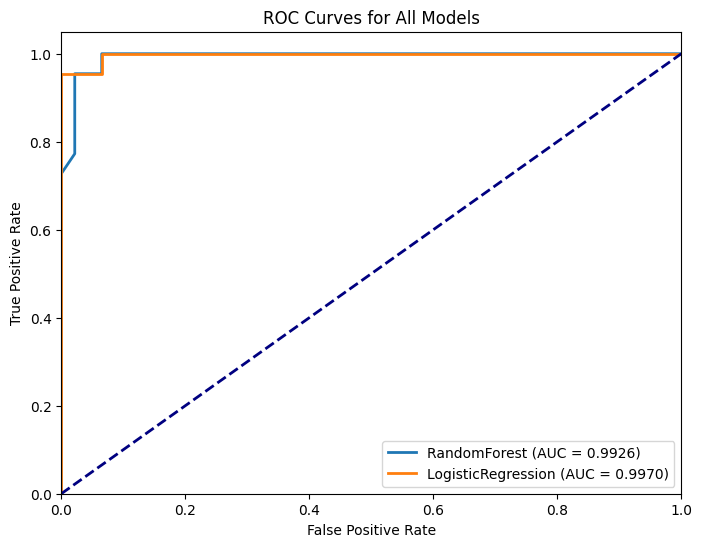

In [ ]:
#@title GRAYSCALE RAW GRAY PIXEL
# Each image is flattened to a 1D vector of the pixel values

train_models(gray_X_train, gray_y_train, gray_X_test, gray_y_test)

--- RandomForest ---
Accuracy: 0.8824
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.87      0.91        46
           1       0.77      0.91      0.83        22

    accuracy                           0.88        68
   macro avg       0.86      0.89      0.87        68
weighted avg       0.89      0.88      0.88        68

ROC AUC: 0.9644


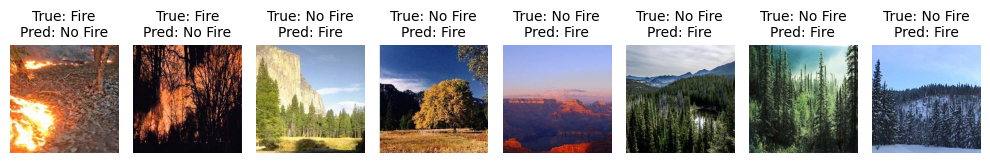

--- LogisticRegression ---
Accuracy: 0.3824
Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.22      0.32        46
           1       0.31      0.73      0.43        22

    accuracy                           0.38        68
   macro avg       0.47      0.47      0.38        68
weighted avg       0.52      0.38      0.36        68

ROC AUC: 0.7569


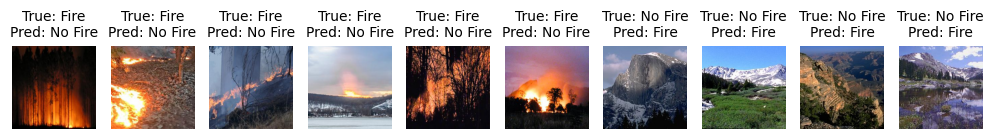

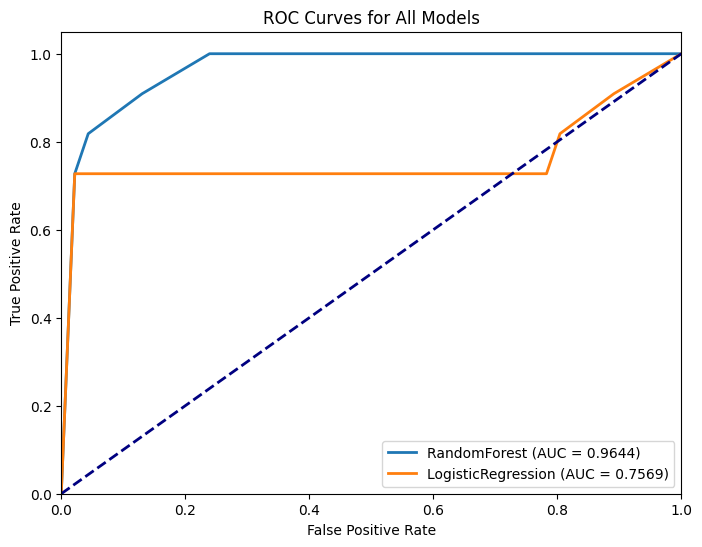

In [ ]:
#@title GRAY SCALE KMEANS CLUSTER LABELS

# Apply K-Means Clustering
k = 6

# This just assigns a cluster label to each image meaning each image only has one feature
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10) # Adjust K (n_clusters) here
gray_X_train_clustered = kmeans.fit_predict(gray_X_train_pca).reshape(-1, 1)
gray_X_test_clustered = kmeans.predict(gray_X_test_pca).reshape(-1, 1)

train_models(gray_X_train_clustered, gray_y_train, gray_X_test_clustered, gray_y_test)

--- RandomForest ---
Accuracy: 0.9559
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97        46
           1       0.95      0.91      0.93        22

    accuracy                           0.96        68
   macro avg       0.95      0.94      0.95        68
weighted avg       0.96      0.96      0.96        68

ROC AUC: 0.9896


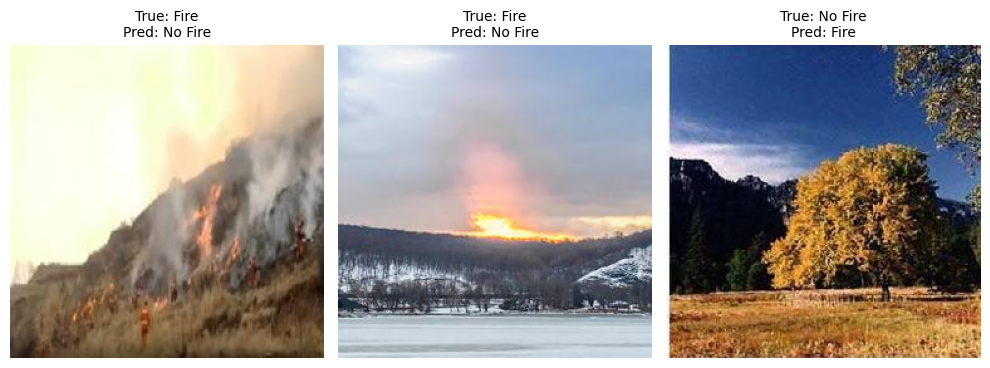

--- LogisticRegression ---
Accuracy: 0.9559
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97        46
           1       0.95      0.91      0.93        22

    accuracy                           0.96        68
   macro avg       0.95      0.94      0.95        68
weighted avg       0.96      0.96      0.96        68

ROC AUC: 0.9931


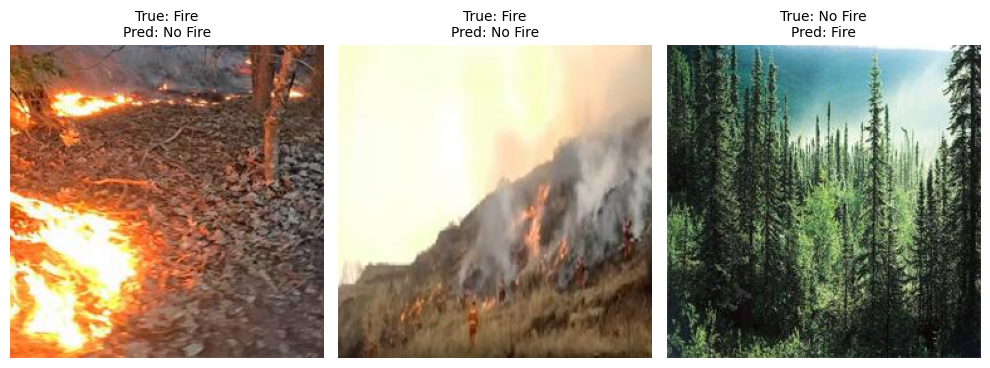

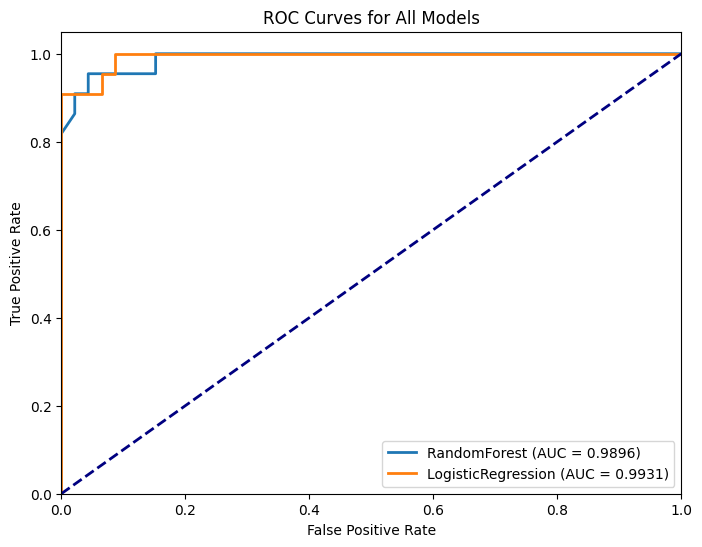

In [ ]:
#@title GRAYSCALE KMEANS CLUSTER DISTANCES


gray_X_train_dist = kmeans.transform(gray_X_train_pca)
gray_X_test_dist = kmeans.transform(gray_X_test_pca)

train_models(gray_X_train_dist, gray_y_train, gray_X_test_dist, gray_y_test)

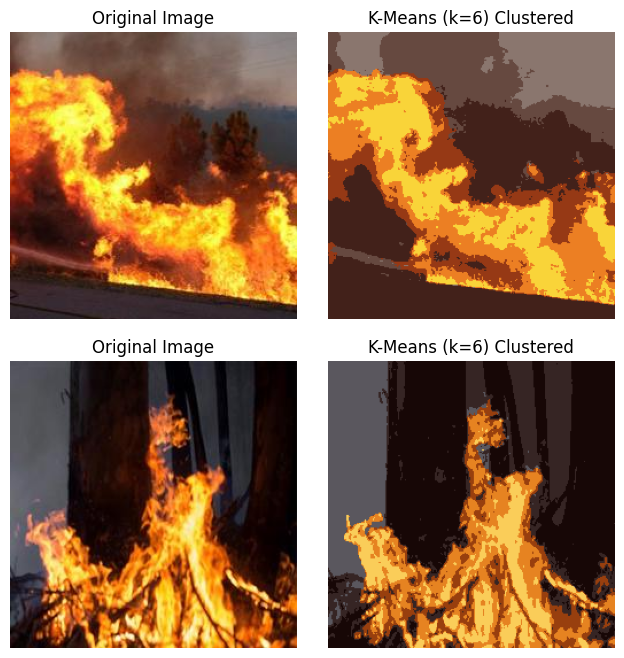

In [ ]:
#@title KMeans Image Visualization

import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from glob import glob

# Select the last two images
sample_images = train_files[3:5]

def apply_kmeans(image_path, k=6):
    """Loads an image, applies K-Means clustering, and returns the clustered image."""
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for correct display

    # Reshape image into a 2D array of pixels
    pixel_values = image.reshape((-1, 3))
    pixel_values = np.float32(pixel_values)

    # Apply KMeans clustering
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(pixel_values)

    # Convert cluster centers to uint8 (color values)
    clustered_image = kmeans.cluster_centers_.astype(np.uint8)[labels]
    clustered_image = clustered_image.reshape(image.shape)

    return image, clustered_image

# Create figure with subplots for 2 images
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))

for i, img_path in enumerate(sample_images):
    original, clustered = apply_kmeans(img_path, k=6)

    axes[i, 0].imshow(original)
    axes[i, 0].axis('off')
    axes[i, 0].set_title("Original Image")

    axes[i, 1].imshow(clustered)
    axes[i, 1].axis('off')
    axes[i, 1].set_title("K-Means (k=6) Clustered")

# Adjust layout to minimize whitespace
plt.subplots_adjust(wspace=0.05, hspace=0.15)
plt.show()
